# Description Generator with Xception (CNN) & LSTM


## Importing Libs

In [2]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-2-79c0a8d2f7e4>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


C:\Users\KASTALLS\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## I - Reading Data
The Flickr8k_text contains the captions of the images.


Thus every line contains the name of the image, caption number (0 to 4) and the actual caption.


We will create a dictionary named “descriptions” which contains the name of the image (without the .jpg extension) as keys and a list of the 5 captions for the corresponding image as values.

In [3]:
dataset_text = "../Flickr8k_text"
filename = dataset_text + "/" + "Flickr8k.token.txt"

In [4]:
# Loading a text file into memory
# Opening the file as read only
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [5]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n') #spli by white space
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [6]:
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))


Length of descriptions = 8092


In [7]:
dict_items = descriptions.items()
first_two = list(dict_items)[:2]
print(first_two)

[('1000268201_693b08cb0e.jpg', ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']), ('1001773457_577c3a7d70.jpg', ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'])]


### 1.1 Text Data Cleaning
When we deal with text, we generally perform some basic cleaning like lower-casing all the words (otherwise“hello” and “Hello” will be regarded as two separate words), removing special tokens (like ‘%’, ‘$’, ‘#’, etc.), eliminating words which contain numbers (like ‘hey199’, etc.).

In [8]:
##Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [9]:
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

In [10]:
dict_items = clean_descriptions.items()
first_two = list(dict_items)[:2]
print(first_two)

[('1000268201_693b08cb0e.jpg', ['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']), ('1001773457_577c3a7d70.jpg', ['black dog and spotted dog are fighting', 'black dog and tricolored dog playing with each other on the road', 'black dog and white dog with brown spots are staring at each other in the street', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other'])]


In [11]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()
    
#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

## 1.2 Vocabulary
Create a vocabulary of all the unique words present across all the 8000*5 (= 40000) image captions 

In [12]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

#building vocabulary 
vocabulary = text_vocabulary(descriptions )
print("Length of vocabulary = ", len(vocabulary))

Length of vocabulary =  8763


In [13]:
vocabulary

{'sleeve',
 'year',
 'hikes',
 'pudding',
 'tugging',
 'sniff',
 'levels',
 'splashing',
 'deserted',
 'supervise',
 'crewmen',
 'deeps',
 'stadning',
 'emits',
 'diapers',
 'including',
 'tap',
 'vampires',
 'applauding',
 'vine',
 'slowly',
 'flop',
 'filling',
 'cameraphone',
 'speedo',
 'shovel',
 'entering',
 'coppery',
 'wife',
 'dimmly',
 'pony',
 'wodden',
 'avoid',
 'prairie',
 'dandelion',
 'challenges',
 'squad',
 'personal',
 'rollerbladers',
 'longspandex',
 'sprinting',
 'employees',
 'trash',
 'roadside',
 'dried',
 'ratty',
 'gear',
 'chunky',
 'swinsuit',
 'marked',
 'tell',
 'swatting',
 'goaltender',
 'tabloid',
 'wristwatch',
 'midjump',
 'artistic',
 'top',
 'lounges',
 'power',
 'logos',
 'faux',
 'sporting',
 'outlined',
 'great',
 'dumpsters',
 'bluetooth',
 'backstroke',
 'broom',
 'maroon',
 'purses',
 'dribbling',
 'layup',
 'fairgrounds',
 'gloves',
 'lookout',
 'fishers',
 'gelled',
 'jumpsuit',
 'ticket',
 'apartment',
 'opening',
 'escorted',
 'heroes',
 

##### We have 8763 unique words across all the 40000 image captions. We write all these captions along with their image names in a new file namely, “descriptions.txt” and save it on the disk.
However, if we think about it, many of these words will occur very few times, say 1, 2 or 3 times. Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. This helps the model become more robust to outliers and make less mistakes.
Hence we consider only those words which occur at least 10 times in the entire corpus. The code for this is below:

In [14]:
all_train_captions = []
for key, val in descriptions.items():
     for cap in val:
        all_train_captions.append(cap)

# # Consider only words which occur at least 8 times in the corpus
word_count_threshold = 8
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ' % len(vocab))


preprocessed words 2246 


## 1.3 Clean descriptions

# 
Thus we have separated the 6000 training images in the list named “train”.
Now, we load the descriptions of these images from “descriptions.txt” in “train_descriptions”.
However, when we load them, we will add two tokens in every caption as follows (significance explained later):
‘startseq’ -> This is a start sequence token which will be added at the start of every caption.
‘endseq’ -> This is an end sequence token which will be added at the end of every caption.

In [15]:
#load the data filename
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)

In [16]:
train_imgs[1]

'2903617548_d3e38d7f88.jpg'

In [17]:


def load_clean_descriptions(filename, photos):   
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions


train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
print('Descriptions: train=%d' % len(train_descriptions))



Descriptions: train=6000


In [18]:
dict_items = train_descriptions.items()
first_two = list(dict_items)[:2]
print(first_two)


[('1000268201_693b08cb0e.jpg', ['<start> child in pink dress is climbing up set of stairs in an entry way <end>', '<start> girl going into wooden building <end>', '<start> little girl climbing into wooden playhouse <end>', '<start> little girl climbing the stairs to her playhouse <end>', '<start> little girl in pink dress going into wooden cabin <end>']), ('1001773457_577c3a7d70.jpg', ['<start> black dog and spotted dog are fighting <end>', '<start> black dog and tricolored dog playing with each other on the road <end>', '<start> black dog and white dog with brown spots are staring at each other in the street <end>', '<start> two dogs of different breeds looking at each other on the road <end>', '<start> two dogs on pavement moving toward each other <end>'])]


## 2.4 Tokenizer
Once fit, the Tokenizer provides 4 attributes that you can use to query what has been learned about your documents:

word_counts: A dictionary of words and their counts.

word_docs: A dictionary of words and how many documents each appeared in.


word_index: A dictionary of words and their uniquely assigned integers.


document_count:An integer count of the total number of documents that were used to fit the Tokenizer.

In [19]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer


In [20]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size 

7577

In [26]:
print ('A dictionary of words and how many documents each appeared in:',tokenizer.word_docs)

A dictionary of words and how many documents each appeared in: defaultdict(<class 'int'>, {'way': 41, 'end': 30000, 'up': 899, 'of': 4617, 'pink': 529, 'climbing': 363, 'an': 1759, 'is': 6637, 'start': 30000, 'entry': 1, 'set': 81, 'in': 12334, 'stairs': 81, 'child': 1094, 'dress': 258, 'into': 755, 'going': 111, 'building': 372, 'wooden': 207, 'girl': 2349, 'playhouse': 6, 'little': 1226, 'to': 2230, 'her': 767, 'the': 10685, 'cabin': 3, 'spotted': 27, 'black': 2736, 'fighting': 97, 'and': 6116, 'are': 2581, 'dog': 5612, 'road': 302, 'with': 5470, 'playing': 1483, 'other': 557, 'each': 315, 'tricolored': 10, 'on': 7598, 'spots': 22, 'white': 2794, 'brown': 1927, 'at': 2056, 'street': 700, 'staring': 43, 'different': 28, 'dogs': 1608, 'two': 4189, 'looking': 558, 'breeds': 5, 'moving': 27, 'pavement': 39, 'toward': 109, 'front': 987, 'paint': 42, 'painted': 50, 'sits': 435, 'hands': 180, 'rainbow': 18, 'covered': 229, 'bowl': 21, 'sitting': 1013, 'large': 878, 'grass': 1221, 'small': 9

In [29]:
print ('A dictionary of words and their uniquely assigned integers.:',tokenizer.word_index)

A dictionary of words and their uniquely assigned integers.: {'end': 1, 'start': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10, 'of': 11, 'two': 12, 'white': 13, 'black': 14, 'boy': 15, 'are': 16, 'woman': 17, 'girl': 18, 'to': 19, 'wearing': 20, 'at': 21, 'people': 22, 'water': 23, 'brown': 24, 'young': 25, 'red': 26, 'an': 27, 'his': 28, 'blue': 29, 'dogs': 30, 'running': 31, 'through': 32, 'playing': 33, 'while': 34, 'down': 35, 'shirt': 36, 'ball': 37, 'standing': 38, 'little': 39, 'grass': 40, 'snow': 41, 'child': 42, 'person': 43, 'jumping': 44, 'over': 45, 'three': 46, 'sitting': 47, 'front': 48, 'field': 49, 'holding': 50, 'small': 51, 'yellow': 52, 'green': 53, 'group': 54, 'up': 55, 'by': 56, 'large': 57, 'one': 58, 'walking': 59, 'her': 60, 'men': 61, 'children': 62, 'air': 63, 'into': 64, 'near': 65, 'mouth': 66, 'beach': 67, 'jumps': 68, 'runs': 69, 'another': 70, 'for': 71, 'street': 72, 'from': 73, 'its': 74, 'riding': 75, 'stands': 76,

# 
Our vocabulary contains 7577 words.

We calculate the maximum length of the descriptions. This is important for deciding the model structure parameters. Max_length of description is 32.

In [31]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

# 2- Feature extraction from images

## 2.1 Loading Image Data in "train" 

In [32]:
dataset_images = "../Flickr8k_Dataset/Flicker8k_Dataset"
dataset_images_filename = '../Flickr8k_Dataset/Flicker8k_Dataset/Flickr_8k.trainImages.txt'

In [33]:
doc = load_doc(filename)
train = list()
for line in doc.split('\n'):
    identifier = line.split('.')[0]
    train.append(identifier)
print('Dataset: %d' % len(train))


Dataset: 6001


## 2.2 Extrcating features from Xception model

In [34]:

def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0
            
            feature = model.predict(image)
            features[img] = feature
        return features

In [24]:
#2048 feature vector
features = extract_features(dataset_images)
features

<ipython-input-23-8ced593b6a79>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


{'1000268201_693b08cb0e.jpg': array([[0.4733971 , 0.01732646, 0.07333975, ..., 0.0855905 , 0.02102301,
         0.23766527]], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([[0.00158209, 0.11113495, 0.00037396, ..., 0.26503602, 0.35279864,
         0.05871643]], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([[0.        , 0.02488977, 0.01554057, ..., 0.        , 0.        ,
         0.10192639]], dtype=float32),
 '1003163366_44323f5815.jpg': array([[0.14568897, 0.00272414, 0.27776545, ..., 0.17018272, 0.11957326,
         0.09414076]], dtype=float32),
 '1007129816_e794419615.jpg': array([[0.        , 0.12443957, 0.73916185, ..., 0.00390436, 0.00997151,
         0.50172323]], dtype=float32),
 '1007320043_627395c3d8.jpg': array([[0.04136695, 0.        , 0.01274474, ..., 0.00944685, 0.64201665,
         0.0479213 ]], dtype=float32),
 '1009434119_febe49276a.jpg': array([[0.        , 0.        , 0.02624732, ..., 0.30528563, 0.230918  ,
         0.14191043]], dtype=float32),
 '1012

In [25]:
dump(features, open("Xception_features.p","wb"))

In [35]:
features = load(open("Xception_features.p","rb"))

In [49]:
features['1000268201_693b08cb0e.jpg']

array([[0.4733971 , 0.01732646, 0.07333975, ..., 0.0855905 , 0.02102301,
        0.23766527]], dtype=float32)

In [65]:
data = list(features.values())
an_array = np.array(data)
an_array

array([[[4.73397106e-01, 1.73264630e-02, 7.33397454e-02, ...,
         8.55904967e-02, 2.10230108e-02, 2.37665266e-01]],

       [[1.58209028e-03, 1.11134946e-01, 3.73957766e-04, ...,
         2.65036017e-01, 3.52798641e-01, 5.87164275e-02]],

       [[0.00000000e+00, 2.48897672e-02, 1.55405654e-02, ...,
         0.00000000e+00, 0.00000000e+00, 1.01926394e-01]],

       ...,

       [[8.91361982e-02, 0.00000000e+00, 4.63757664e-02, ...,
         4.69628781e-01, 8.92081019e-03, 1.41723961e-01]],

       [[1.53899133e-01, 2.69507896e-03, 2.62173206e-01, ...,
         0.00000000e+00, 0.00000000e+00, 1.43675394e-02]],

       [[3.60692590e-02, 0.00000000e+00, 0.00000000e+00, ...,
         2.69028042e-02, 9.81608499e-03, 6.03638440e-02]]], dtype=float32)

In [89]:
amat=np.asmatrix( an_array)


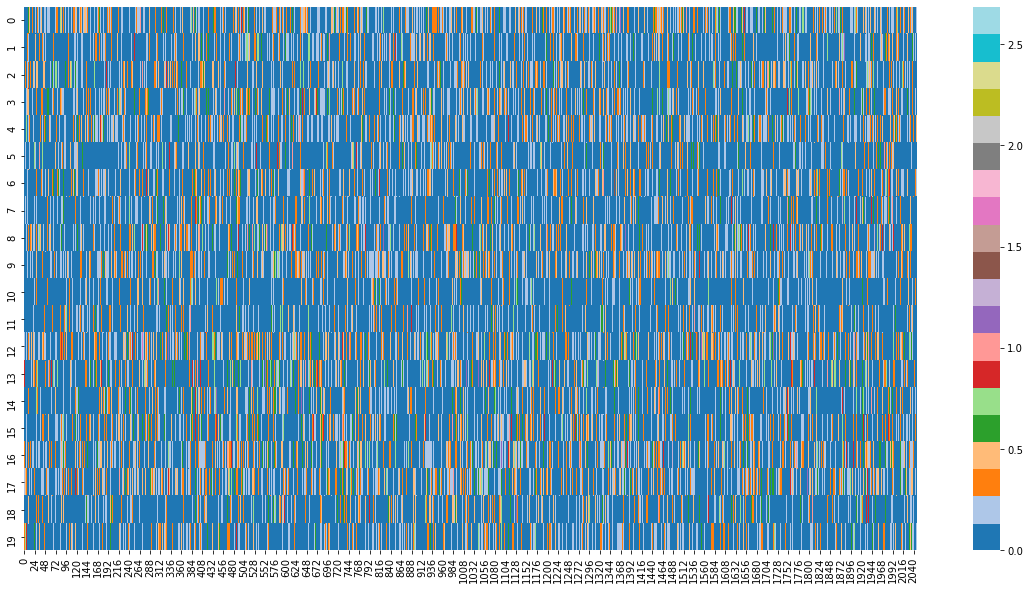

In [88]:
f, ax = plt.subplots(figsize=(20, 10))
ax = sns.heatmap(amat[:20,:],cmap='tab20')

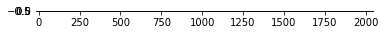

In [57]:
import matplotlib.pyplot as plt
ax = plt.imshow(features['1000268201_693b08cb0e.jpg'],cmap='hot', interpolation='nearest')
plt.show()

## 2.3 Loading Image file name in "train_imgs" 

In [90]:
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


train_features = load_features(train_imgs)


In [82]:
len(train_features)

6000

In [48]:
features['1000268201_693b08cb0e.jpg']

array([[0.4733971 , 0.01732646, 0.07333975, ..., 0.0855905 , 0.02102301,
        0.23766527]], dtype=float32)

# 3 - Define the model

#1 Photo feature extractor - we extracted features from pretrained model Xception. 

#2 Sequence processor - word embedding layer that handles text, followed by LSTM 

#3 Decoder - Both 1 and 2 model produce fixed length vector. They are merged together and processed by dense layer to make final prediction

#
Let us first see how the input and output of our model will look like. To make this task into a supervised learning task, we have to provide input and output to the model for training. We have to train our model on 6000 images and each image will contain 2048 length feature vector and caption is also represented as numbers. This amount of data for 6000 images is not possible to hold into memory so we will be using a generator method that will yield batches.

The generator will yield the input and output sequence.

For example:

The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

## 3.1 Data generator 

In [84]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)
          
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [85]:
[a,b],c = next(data_generator(train_descriptions, train_features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

In [95]:
# train our model

print('Descriptions: train =', len(train_descriptions))
print('Vocabulary Size:', vocab_size)
print('Max Description Length: ', max_length)
print('Photos: train =', len(train_features))
print('Number of features for each Image: ', len(features['1000268201_693b08cb0e.jpg'][0]))




Descriptions: train = 6000
Vocabulary Size: 7577
Max Description Length:  32
Photos: train = 6000
Number of features for each Image:  2048


## 3.2 Define model 

In [33]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    
    return model

In [34]:
model = define_model(vocab_size, max_length)



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 32, 256)      1939712     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
______________________________________________________________________________________________

## 3.3 Print Model

In [35]:
plot_model(model, to_file='model1.png', show_shapes=True,show_layer_names=True,    rankdir="TB",    expand_nested=False)
    

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## 3.4 Fit Model

In [36]:
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

C:\Users\KASTALLS\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 924s 154ms/step - loss: 2.8096


In [39]:
[a,b],c =next(generator)
a.shape, b.shape, c.shape

((68, 2048), (68, 32), (68, 7577))

# 4 - Testing phase

In [99]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.models import load_model
from pickle import load
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import argparse

In [100]:
def extract_featurestest(filename, model):
        try:
            image = Image.open(filename)
            
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final




## 4.1 Testing on other pictures




man in red jacket is standing on mountain


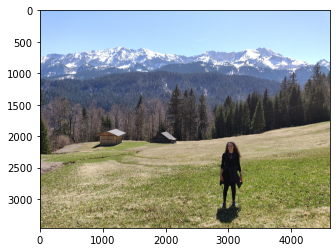

In [119]:
img_path = '..\IMG_20190421_125733.jpg' 
#img_path = 'D:\DCIM\oneplus\1.jpg'
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
xception_model = Xception(include_top=False, pooling="avg")
#model = load_model('models/model_9.h5')
photo = extract_featurestest(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

## 4.2 Automatic testing on the test set

In [105]:
model = load_model('models/model_9.h5')

In [106]:
# Below path contains all the images
import glob
images = '../Flickr8k_Dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

# Below file conatains the names of images to be used in test data
test_images_file = '../Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test image
        
        
i=0

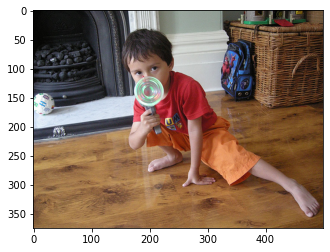

Generate description with Xception: young boy in pink shirt is walking on the sidewalk


In [121]:
img_path=test_img[i]
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_featurestest(img_path, xception_model)

img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)

plt.imshow(img)
plt.show()
print("Generate description with Xception:",description)
i+=1